In [1]:
import pandas as pd
import sys
import torch
from tqdm import tqdm
import scanpy as sc

sys.path.append('/work/magroup/kaileyhu/synthetic_lethality/prediction/regression')

from regression_loader import reg_dataset, DatasetType, reg_dataset_unlabeled
from net import Net768

In [2]:
bp_dict = {'BRCA1' : 'ENSG00000012048', 'BRCA2' : 'ENSG00000139618', 'PARP1' : 'ENSG00000143799', 'PARP2' : 'ENSG00000129484'}

In [3]:
dual_ko_file = f"/work/magroup/kaileyhu/res/perturbed/DUAL_BRCA_PARP/subtracted_embs"

brca1_parp1_file = f"{dual_ko_file}/{bp_dict['BRCA1']} {bp_dict['PARP1']} .csv"
brca2_parp1_file = f"{dual_ko_file}/{bp_dict['BRCA2']} {bp_dict['PARP1']} .csv"

brca1_parp2_file = f"{dual_ko_file}/{bp_dict['BRCA1']} {bp_dict['PARP2']} .csv"
brca2_parp2_file = f"{dual_ko_file}/{bp_dict['PARP2']} {bp_dict['BRCA2']} .csv"

brca1_parp1_df = pd.read_csv(brca1_parp1_file)
brca2_parp1_df = pd.read_csv(brca2_parp1_file)

brca1_parp2_df = pd.read_csv(brca1_parp2_file)
brca2_parp2_df = pd.read_csv(brca2_parp2_file)

brca1_parp1_df.drop(columns = 'viability', inplace = True)
brca2_parp1_df.drop(columns = 'viability', inplace = True)
brca1_parp2_df.drop(columns = 'viability', inplace = True)
brca2_parp2_df.drop(columns = 'viability', inplace = True)

In [4]:
esm2_embs = pd.read_csv("/work/magroup/kaileyhu/res/gene_embeddings/ESM_pca_256.csv")
esm2_embs.set_index("Unnamed: 0", inplace = True)

In [5]:
brca1_emb = esm2_embs.loc[bp_dict["BRCA1"]]
brca2_emb = esm2_embs.loc[bp_dict["BRCA2"]]
parp1_emb = esm2_embs.loc[bp_dict["PARP1"]]
parp2_emb = esm2_embs.loc[bp_dict["PARP2"]]

In [6]:
single_ko_file = f"/work/magroup/kaileyhu/res/perturbed/gf_12L_30M_i2048_SL/subtracted_embs"

brca1_file = f"{single_ko_file}/{bp_dict['BRCA1']}.csv"
brca2_file = f"{single_ko_file}/{bp_dict['BRCA2']}.csv"
parp1_file = f"{single_ko_file}/{bp_dict['PARP1']}.csv"
parp2_file = f"{single_ko_file}/{bp_dict['PARP2']}.csv"

brca1_with_nan = pd.read_csv(brca1_file)
brca2_with_nan = pd.read_csv(brca2_file)
parp1_with_nan = pd.read_csv(parp1_file)
parp2_with_nan = pd.read_csv(parp2_file)

In [7]:
to_concat = [brca1_emb for _ in range(len(brca1_with_nan))]
to_concat_df = pd.DataFrame(to_concat)
to_concat_df.index = brca1_with_nan.index
brca1 = pd.concat([brca1_with_nan, to_concat_df], axis = 1)

to_concat = [brca2_emb for _ in range(len(brca2_with_nan))]
to_concat_df = pd.DataFrame(to_concat)
to_concat_df.index = brca2_with_nan.index
brca2 = pd.concat([brca2_with_nan, to_concat_df], axis = 1)

to_concat = [parp1_emb for _ in range(len(parp1_with_nan))]
to_concat_df = pd.DataFrame(to_concat)
to_concat_df.index = parp1_with_nan.index
parp1 = pd.concat([parp1_with_nan, to_concat_df], axis = 1)

to_concat = [parp2_emb for _ in range(len(parp2_with_nan))]
to_concat_df = pd.DataFrame(to_concat)
to_concat_df.index = parp2_with_nan.index
parp2 = pd.concat([parp2_with_nan, to_concat_df], axis = 1)

In [8]:
brca1.set_index("patient_id", inplace = True)
brca2.set_index("patient_id", inplace = True)
parp1.set_index("patient_id", inplace = True)
parp2.set_index("patient_id", inplace = True)

In [9]:
cols = list(brca1.columns)
cols = cols[1:] + [cols[0]]

In [10]:
brca1 = brca1[cols]
brca2 = brca2[cols]
parp1 = parp1[cols]
parp2 = parp2[cols]

In [11]:
def avg_embeddings(e1, e2):
    res = []
    e1 = list(e1)
    e2 = list(e2)
    for i in range(len(e1)):
        res.append(0.5 * (e1[i] + e2[i]))
    return res

In [12]:
b1_p1_emb = avg_embeddings(brca1_emb, parp1_emb)
b1_p2_emb = avg_embeddings(brca1_emb, parp2_emb)
b2_p1_emb = avg_embeddings(brca2_emb, parp1_emb)
b2_p2_emb = avg_embeddings(brca2_emb, parp2_emb)

In [13]:
to_concat = [b1_p1_emb for _ in range(len(brca1_parp1_df))]
to_concat_df = pd.DataFrame(to_concat, columns = [f"pc {i}" for i in range(256)])
to_concat_df.index = brca1_parp1_df.index
brca1_parp1 = pd.concat([brca1_parp1_df, to_concat_df], axis = 1)

to_concat = [b2_p1_emb for _ in range(len(brca2_parp1_df))]
to_concat_df = pd.DataFrame(to_concat, columns = [f"pc {i}" for i in range(256)])
to_concat_df.index = brca2_parp1_df.index
brca2_parp1 = pd.concat([brca2_parp1_df, to_concat_df], axis = 1)

to_concat = [b1_p2_emb for _ in range(len(brca1_parp2_df))]
to_concat_df = pd.DataFrame(to_concat, columns = [f"pc {i}" for i in range(256)])
to_concat_df.index = brca1_parp2_df.index
brca1_parp2 = pd.concat([brca1_parp2_df, to_concat_df], axis = 1)

to_concat = [b2_p2_emb for _ in range(len(brca2_parp2_df))]
to_concat_df = pd.DataFrame(to_concat, columns = [f"pc {i}" for i in range(256)])
to_concat_df.index = brca2_parp2_df.index
brca2_parp2 = pd.concat([brca2_parp2_df, to_concat_df], axis = 1)

In [14]:
brca1_parp1.set_index("patient_id", inplace = True)
brca2_parp1.set_index("patient_id", inplace = True)
brca1_parp2.set_index("patient_id", inplace = True)
brca2_parp2.set_index("patient_id", inplace = True)

In [15]:
b1p1_loader = reg_dataset_unlabeled(brca1_parp1)
b2p1_loader = reg_dataset_unlabeled(brca2_parp1)
b1p2_loader = reg_dataset_unlabeled(brca1_parp2)
b2p2_loader = reg_dataset_unlabeled(brca2_parp2)

In [16]:
orig_df = pd.read_csv("/work/magroup/kaileyhu/res/IMPORTANT/orig_embedding_SL.csv")
orig_df.set_index("patient_id", inplace = True)

to_concat = [[0.0 for i in range(256)] for _ in range(len(orig_df))]
to_concat_df = pd.DataFrame(to_concat, columns = [f"pc {i}" for i in range(256)])
to_concat_df.index = orig_df.index
orig_df = pd.concat([orig_df, to_concat_df], axis = 1)

In [17]:
path = "/work/magroup/kaileyhu/synthetic_lethality/prediction/regression"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Found device {device}")

net = Net768()

net.to(device)

model_path = f"{path}/models/ESM2/feb_5_100_e_0.001_lr_128_b.pth"
net.load_state_dict(torch.load(model_path, weights_only=True))

Found device cuda:0


<All keys matched successfully>

### brca1 parp1

In [18]:
vals = []
patient_to_pred = {}

with torch.no_grad():
    for i, d in tqdm(enumerate(b1p1_loader)):
        inputs, names = d
        inputs = inputs.float().to(device)
        
        outputs = net(inputs)
        predicted = outputs.data

        vals.append(predicted.item())
        patient_to_pred[names] = predicted.item()

580it [00:04, 118.88it/s]


In [19]:
valid_patients = set(patient_to_pred.keys()).intersection((brca1.index), (parp1.index))

In [20]:
b1p1_orig_df = orig_df.loc[list(valid_patients)]
b1p1_brca1 = brca1.loc[list(valid_patients)].dropna()
b1p1_parp1 = parp1.loc[list(valid_patients)].dropna()

In [21]:
brca1_parp1["viability"] = brca1_parp1.index.map(patient_to_pred)
b1p1_orig_df["viability"] = [0.0 for _ in range(len(b1p1_orig_df.index))]

In [22]:
b1p1_orig_df["type"] = ["unperturbed" for _ in range(len(b1p1_orig_df.index))]
b1p1_brca1["type"] = ["brca1 ko" for _ in range(len(b1p1_brca1.index))]
b1p1_parp1["type"] = ["parp1 ko" for _ in range(len(b1p1_parp1.index))]
brca1_parp1["type"] = ["brca1 parp1 ko" for _ in range(len(brca1_parp1.index))]

### brca1 parp2

In [23]:
vals = []
patient_to_pred = {}

with torch.no_grad():
    for i, d in tqdm(enumerate(b1p2_loader)):
        inputs, names = d
        inputs = inputs.float().to(device)
        
        outputs = net(inputs)
        predicted = outputs.data

        vals.append(predicted.item())
        patient_to_pred[names] = predicted.item()

1199it [00:00, 5542.46it/s]


In [24]:
valid_patients = set(patient_to_pred.keys()).intersection((brca1.index), (parp2.index))

In [25]:
b1p2_orig_df = orig_df.loc[list(valid_patients)]
b1p2_brca1 = brca1.loc[list(valid_patients)].dropna()
b1p2_parp1 = parp2.loc[list(valid_patients)].dropna()

In [26]:
brca1_parp2["viability"] = brca1_parp2.index.map(patient_to_pred)
b1p2_orig_df["viability"] = [0.0 for _ in range(len(b1p2_orig_df.index))]

In [27]:
b1p2_orig_df["type"] = ["unperturbed" for _ in range(len(b1p2_orig_df.index))]
b1p2_brca1["type"] = ["brca1 ko" for _ in range(len(b1p2_brca1.index))]
b1p2_parp1["type"] = ["parp2 ko" for _ in range(len(b1p2_parp1.index))]
brca1_parp2["type"] = ["brca1 parp2 ko" for _ in range(len(brca1_parp2.index))]

### brca2 parp1

In [28]:
vals = []
patient_to_pred = {}

with torch.no_grad():
    for i, d in tqdm(enumerate(b2p1_loader)):
        inputs, names = d
        inputs = inputs.float().to(device)
        
        outputs = net(inputs)
        predicted = outputs.data

        vals.append(predicted.item())
        patient_to_pred[names] = predicted.item()

34it [00:00, 4222.37it/s]


In [29]:
valid_patients = set(patient_to_pred.keys()).intersection((brca2.index), (parp1.index))

In [30]:
b2p1_orig_df = orig_df.loc[list(valid_patients)]
b2p1_brca1 = brca2.loc[list(valid_patients)].dropna()
b2p1_parp1 = parp1.loc[list(valid_patients)].dropna()

In [31]:
brca2_parp1["viability"] = brca2_parp1.index.map(patient_to_pred)
b2p1_orig_df["viability"] = [0.0 for _ in range(len(b2p1_orig_df.index))]

In [32]:
b2p1_orig_df["type"] = ["unperturbed" for _ in range(len(b2p1_orig_df.index))]
b2p1_brca1["type"] = ["brca2 ko" for _ in range(len(b2p1_brca1.index))]
b2p1_parp1["type"] = ["parp1 ko" for _ in range(len(b2p1_parp1.index))]
brca2_parp1["type"] = ["brca2 parp1 ko" for _ in range(len(brca2_parp1.index))]

### brca2 parp 2

In [33]:
vals = []
patient_to_pred = {}

with torch.no_grad():
    for i, d in tqdm(enumerate(b2p2_loader)):
        inputs, names = d
        inputs = inputs.float().to(device)
        
        outputs = net(inputs)
        predicted = outputs.data

        vals.append(predicted.item())
        patient_to_pred[names] = predicted.item()

53it [00:00, 3979.34it/s]


In [34]:
valid_patients = set(patient_to_pred.keys()).intersection((brca2.index), (parp2.index))

In [35]:
b2p2_orig_df = orig_df.loc[list(valid_patients)]
b2p2_brca1 = brca2.loc[list(valid_patients)].dropna()
b2p2_parp1 = parp2.loc[list(valid_patients)].dropna()

brca2_parp2["viability"] = brca2_parp2.index.map(patient_to_pred)
b2p2_orig_df["viability"] = [0.0 for _ in range(len(b2p2_orig_df.index))]

In [36]:
b2p2_orig_df["type"] = ["unperturbed" for _ in range(len(b2p2_orig_df.index))]
b2p2_brca1["type"] = ["brca2 ko" for _ in range(len(b2p2_brca1.index))]
b2p2_parp1["type"] = ["parp2 ko" for _ in range(len(b2p2_parp1.index))]
brca2_parp2["type"] = ["brca2 parp2 ko" for _ in range(len(brca2_parp2.index))]

In [37]:
df_full_adata = pd.concat([b1p1_orig_df, b1p1_brca1, b1p1_parp1, brca1_parp1,
                           b1p2_orig_df, b1p2_brca1, b1p2_parp1, brca1_parp2,
                           b2p1_orig_df, b2p1_brca1, b2p1_parp1, brca2_parp1,
                           b2p2_orig_df, b2p2_brca1, b2p2_parp1, brca2_parp2,])

In [38]:
adata = sc.AnnData(df_full_adata.drop(columns = ['Unnamed: 0', 'viability', 'type']))

/home/kaileyhu/anaconda3/envs/geneformer/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [39]:
adata.obs['pred'] = df_full_adata["viability"]
adata.obs['type'] = df_full_adata["type"]

In [40]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/kaileyhu/anaconda3/envs/geneformer/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 768 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
2025-04-01 13:11:01.379200: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 13:11:02.524002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 13:11:03.131207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already be

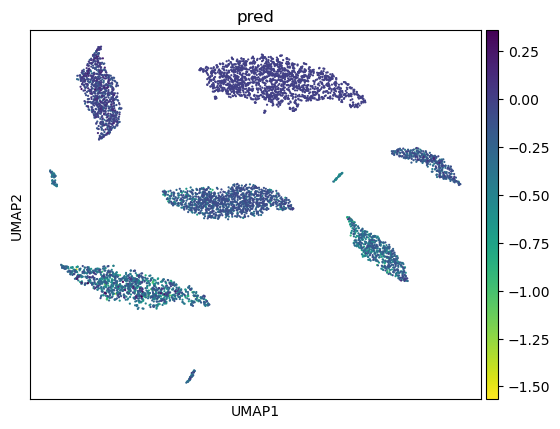

In [51]:
sc.pl.umap(
    adata,
    color="pred",
    # Setting a smaller point size to get prevent overlap
    size=10,
    cmap = 'viridis_r'
)

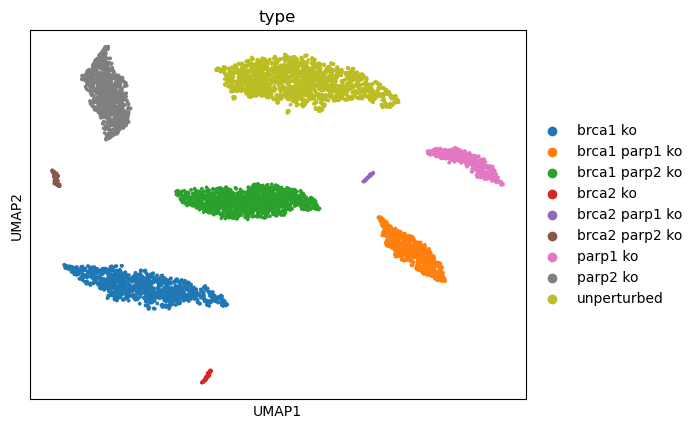

In [42]:
sc.pl.umap(
    adata,
    color="type",
    # Setting a smaller point size to get prevent overlap
    size=30,
)